# **Tire Count Replacement**
### Author: *Zacchaeus Williams*
### Date: 02/25/2021

The objective of this case study is that given the tables `assigntarget_exception`, `assigntarget_tire`, and `tread_depth_lk`, write a Python script that will **classify how many full-sized replacement tires should be ordered** considering pre-defined features.

## Import Libraries

In [254]:
import os
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, DenseFeatures, concatenate
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Normalization, StringLookup, CategoryEncoding, IntegerLookup
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, confusion_matrix, make_scorer, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Read Data into Environment

I use **pandas** here to open the doors of it's data manipulation capabilities. However, there are other more efficient ways to read in this type of data for more robust automated ML pipelines.

In [3]:
assigntarget_exception = pd.read_csv('assigntarget_exception.csv')
assigntarget_tire = pd.read_csv('assigntarget_tire.csv')
tread_depth_lk = pd.read_csv('tread_depth_lk.csv')
vehicle = pd.read_csv('vehicle.csv')

print(f'Shape of Exception Data  : {assigntarget_exception.shape}')
print(f'Shape of Tire Data       : {assigntarget_tire.shape}')
print(f'Shape of Tread Depth Data: {tread_depth_lk.shape}')
print(f'Shape of Vehicle Data    : {vehicle.shape}')

Shape of Exception Data  : (23789, 4)
Shape of Tire Data       : (10000, 10)
Shape of Tread Depth Data: (62, 4)
Shape of Vehicle Data    : (1978, 3)


In [5]:
# lowercase all columns to make joining the dataframes easier

assigntarget_tire.columns = [c.lower() for c in assigntarget_tire.columns]
tread_depth_lk.columns = [c.lower() for c in tread_depth_lk.columns]

for c in [assigntarget_exception, assigntarget_tire, tread_depth_lk, vehicle]:
    print(c.columns)

Index(['assign_target_id', 'part_code', 'damage_code', 'severity_code'], dtype='object')
Index(['assigntarget_tire_id', 'assign_target_id', 'tire_brand_guid',
       'rim_size_guid', 'lateral_position_type', 'longitude_position_type',
       'secondary_position_type', 'tread_depth_guid', 'create_userguid',
       'create_date'],
      dtype='object')
Index(['tread_depth_guid', 'name', 'create_userguid', 'create_date'], dtype='object')
Index(['assign_target_id', 'model_year', 'mileage'], dtype='object')


In [184]:
# Inner Join dataframes to ensure I gain as much information about the aggregated data as possible

df = assigntarget_exception\
        .merge(assigntarget_tire, on='assign_target_id')\
        .merge(vehicle, on='assign_target_id')\
        .merge(tread_depth_lk[['tread_depth_guid', 'name']], on='tread_depth_guid')

print(f'Joined Data Shape: {df.shape}')
df.head()

Joined Data Shape: (118394, 16)


,assign_target_id,part_code,damage_code,severity_code,assigntarget_tire_id,tire_brand_guid,rim_size_guid,lateral_position_type,longitude_position_type,secondary_position_type,tread_depth_guid,create_userguid,create_date,model_year,mileage,name
0,13780040,8313,17,69,56374318,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,REAR,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32"""
1,13780040,8313,17,69,56374319,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,SECONDAXLE,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32"""
2,13780040,8313,17,69,56374320,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,RIGHT,REAR,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32"""
3,13780040,8313,17,69,56374321,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,RIGHT,SECONDAXLE,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32"""
4,13780040,8151,89,15,56374318,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,REAR,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32"""


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118394 entries, 0 to 118393
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   assign_target_id         118394 non-null  int64  
 1   part_code                118394 non-null  int64  
 2   damage_code              118394 non-null  int64  
 3   severity_code            118394 non-null  int64  
 4   assigntarget_tire_id     118394 non-null  int64  
 5   tire_brand_guid          118394 non-null  object 
 6   rim_size_guid            118394 non-null  object 
 7   lateral_position_type    118394 non-null  object 
 8   longitude_position_type  118394 non-null  object 
 9   secondary_position_type  118394 non-null  object 
 10  tread_depth_guid         118394 non-null  object 
 11  create_userguid          118394 non-null  object 
 12  create_date              118394 non-null  object 
 13  model_year               118394 non-null  int64  
 14  mile

Only **full-sized** tires are required for this experiment, therefore I remove information about `SPARE` and `INSIDE` tires from my dataset.

In [186]:
print(f'Dropping {len(df)-len(df.drop_duplicates())} duplicate rows in the dataframe...')
df = df[df.secondary_position_type=='(null)']
df = df.drop_duplicates()
print('Done!')
print(f'New Data Shape: {df.shape}')

Dropping 42 duplicate rows in the dataframe...
Done!
New Data Shape: (94787, 16)


As per the instructions, a tire will need to be replaced considering the following:

- It has tread depth 3/32" or less **OR**
- `part_code` = 1290, `damage_code` = 10, `severity_code` = 71 (left front tire has low tread depth and needs replaced)
- `part_code` = 1300, `damage_code` = 10, `severity_code` = 71 (left rear tire has low tread depth and needs replaced) 
- `part_code` = 1310, `damage_code` = 10, `severity_code` = 71 (right front tire has low tread depth and needs replaced)
- `part_code` = 1320, `damage_code` = 10, `severity_code` = 71 (right rear tire has low tread depth and needs replaced)

To ensure I develop this criteria correctly, I'd need to parse the `name` column to satisfy the first point.

In [187]:
df.name.value_counts()

5/32"               15041
6/32"               14980
7/32"               13654
4/32"               11413
8/32"               10354
3/32"                8991
9/32"                5506
2/32"                4750
10/32"               2959
1/32"                2269
0/32"                1625
12/32"               1397
11/32"                979
13/32"                274
14/32"                195
15/32"                129
18/32"                 57
17/32"                 56
Worn (<3/32")          54
2 mm                   36
1 mm                   30
Replace (<3/32")       18
Worn (2/32")           11
3 mm                    6
16/32"                  3
Name: name, dtype: int64

In [188]:
len(df[df.name.isin(['Worn (<3/32")', 'Replace (<3/32")', 'Worn (2/32")', '0/32"', '1/32"', '2/32"', '3/32"', '1 mm', '2 mm'])])

17784

The code for the last 4 points are fairly simple to query/filter.

In [189]:
len(df[(df['part_code'].isin([1290,1300,1310,1320])) & (df['damage_code']==10) & (df['severity_code']==71)])

2684

Putting it all together in a function to apply to the entire dataset. The output is a new column that will establish whether a particular tire and it's features will need to be replaced or not.

In [191]:
def needs_replaced(df):
    if df['name'] in ['Worn (<3/32")', 'Replace (<3/32")', 'Worn (2/32")', '0/32"', '1/32"', '2/32"', '3/32"', '1 mm', '2 mm']:
        return 1
    elif (df['part_code'] in [1290,1300,1310,1320]) and (df['damage_code']==10) and (df['severity_code']==71):
        return 1
    else:
        return 0

df['needs_replaced'] = df.apply(needs_replaced, axis=1)
df.head()

,assign_target_id,part_code,damage_code,severity_code,assigntarget_tire_id,tire_brand_guid,rim_size_guid,lateral_position_type,longitude_position_type,secondary_position_type,tread_depth_guid,create_userguid,create_date,model_year,mileage,name,needs_replaced
0,13780040,8313,17,69,56374318,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,REAR,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32""",0
1,13780040,8313,17,69,56374319,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,SECONDAXLE,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32""",0
2,13780040,8313,17,69,56374320,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,RIGHT,REAR,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32""",0
3,13780040,8313,17,69,56374321,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,RIGHT,SECONDAXLE,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32""",0
4,13780040,8151,89,15,56374318,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,REAR,(null),177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2020-01-01 15:59:42,2018,1.0,"8/32""",0


In [192]:
df.needs_replaced.value_counts() # Checking the distribution of replaced tires (0 for False, 1 for True)

0    75934
1    18853
Name: needs_replaced, dtype: int64

In [193]:
df.needs_replaced.value_counts(normalize=True)

0    0.801101
1    0.198899
Name: needs_replaced, dtype: float64

## Target Development

Developing the target is quite tricky. This is due to the fact each sample in the dataset doesn't represent a single tire, but possibly many different variations of the same tire. Because of this, one variation of a specific tire on one vehicle (`assign_target_id`) may need to be replaced, but a different variation for the same vehicle will. 

The current `needs_replaced` variable can appear `True` 20+ times for a single vehicle although each vehicle only have 4 tires. This is partly because the variations between `part_code`, `damage_code`, and `severity_code` for a specific tire (`assigntarget_tire_id`) for a vehicle.

To solve this, there were a sequence of transformations that needed to be done.

- **Group by** vehicles (`assign_target_id`) and it's tires (`assigntarget_tire_id`), then sum up the number of tires that needs to be replaced (`needs_replaced`).
- **Filter** for the vehicles that has at least 1 tire that needs to be replaced.
- **Group by** the vehicles and count how many tires it has that needs to be replaced.
- **Left join** the filtered dataset to the original dataset with the new target variable (`num_tires_replaced`), then fill the NAs of that column with zeros.

In [220]:
num_replaced_df = df.groupby(['assign_target_id', 'assigntarget_tire_id'])['needs_replaced'].apply(lambda x: (x==1).sum()).reset_index(name='num_replaced')
num_replaced_df = num_replaced_df[num_replaced_df['num_replaced']>0]
num_replaced_df = num_replaced_df.groupby('assign_target_id')['num_replaced'].count().reset_index(name='num_tires_replaced')

df_final = df.merge(num_replaced_df, on='assign_target_id', how='left')
df_final = df_final.drop('needs_replaced', axis=1)
df_final['num_tires_replaced'] = df_final['num_tires_replaced'].fillna(0).astype(int)

print(f'Final Data Shape: {df_final.shape}')

Final Data Shape: (94787, 17)


There is a significant imbalance, as expected, for the number of replacements.

In [221]:
df_final.num_tires_replaced.value_counts()

0    61373
4    26640
2     2968
1     2666
3     1140
Name: num_tires_replaced, dtype: int64

## **Zack's Exploratory Data Analysis**
My overall objective when I first look to develop a model is to form a **baseline**. To do so, my initial EDA and even *Feature Engineering* is minimal. The reason behind this is I want to really observe how good of a model I can develop without extensive engineering or manipulating of the data.

My EDA process will go as follows:

* **Split Data by Numerical & Categorical Features:** This really makes analysis, feature engineering, and modeling quite easy for to keep the features organized.
* **Observe the Target's distribution to see if I will need to handle data imbalance:** Data Imbalance is a very common problem in industry so its imperative check. Solving this can be quite hard as I'll have to choose between Oversampling & Undersampling to rebalance the data. This could possibly skew your model's results.
* **Check for Missing Values:** Because data isn't always clean and data quality can sometimes be poor, understand how much of the data is missing is key to the cleaning phase.
* **Check for High Cardinality:** If features have high cardinality, it could damage the model. It's important to either remove or bin the features.
* **Check Numerical Distributions:** The distributions can help identify a few things. One is how to handle its missing values if needed. Another is to see if that numerical value should actually be categorical. One last reason to look at numerical distributions is to see whether the feature has very low variation in its values which let's us know that the feature doesn't carry much information for our model to learn from.
* **Check Correlation Matrix:** Features that are highly correlated doesn't need to be present in our model.



In [222]:
ignore_cols = ['assign_target_id', 'assigntarget_tire_id', 'secondary_position_type', 'create_date'] # initial columns I'm choosing to ignore

def split_num_cat_features(df, target=None, defined_numerical_cols=None, defined_categorical_cols=None):
    if defined_numerical_cols != None:
        numerical_features = defined_numerical_cols
    else: 
        numerical_features   = [col for col in df if df[col].dtype==float or df[col].dtype==int and col!=target]
    
    if defined_categorical_cols != None:
        categorical_features = defined_categorical_cols
    else: 
        categorical_features = [col for col in df.columns if col not in numerical_features and col!=target]
    
    return target, numerical_features, categorical_features

defined_numerical_cols = ['mileage']
target, numerical_features, categorical_features = split_num_cat_features(df_final, 'num_tires_replaced', 
                                                                          defined_numerical_cols=defined_numerical_cols)

print(numerical_features)
print(categorical_features)

['mileage']
['assign_target_id', 'part_code', 'damage_code', 'severity_code', 'assigntarget_tire_id', 'tire_brand_guid', 'rim_size_guid', 'lateral_position_type', 'longitude_position_type', 'secondary_position_type', 'tread_depth_guid', 'create_userguid', 'create_date', 'model_year', 'name']


In [206]:
# Missing values
def check_missing_values(df, missing_thresh=60.0, zero_thresh=40.0):
    missing_zeros_df = pd.DataFrame({
        'percent_missing': round(df.isna().sum() * 100/len(df),2),
        'percent_zero': round(df.isin([0]).sum() * 100 / len(df),2),
        # 'percent_null': round(df.isnull().sum() * 100 / len(df),2)
    }).sort_values(['percent_missing', 'percent_zero'], ascending=False)
    
    high_missing_zeros = missing_zeros_df[(missing_zeros_df.percent_missing > missing_thresh) \
                                          | (missing_zeros_df.percent_zero > zero_thresh)].index
    
    return missing_zeros_df, list(high_missing_zeros)

# Plot Numerical Feature Distributions
def plot_num_hist(df, c, i, bins=10):
    plt.figure(i)
    sns.distplot(df[c], bins=bins)
    plt.title(f"Distribution of {c.upper()} Feature... ")

# Cardinality Table
def create_cardinality_table(df, cat_features, threshold=0.05):
    cardinality_df = pd.DataFrame(df[cat_features] \
                        .apply(pd.Series.nunique) \
                        .sort_values(ascending=False),
                        columns=['Cardinality'])
    high_card_cols = cardinality_df[cardinality_df.Cardinality > len(df)*threshold].index
    return cardinality_df, list(high_card_cols)

# Correlation Heatmap
def check_correlation(df):
    corrMatrix = df.corr()
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
    plt.show()

In [207]:
missing_zeros_df, high_missing_zeros_cols = check_missing_values(df_final)
print(f'Columns with High Missing/Zero Values: {high_missing_zeros_cols}')
pd.DataFrame(missing_zeros_df)

Columns with High Missing/Zero Values: ['num_tires_replaced']


,percent_missing,percent_zero
num_tires_replaced,0.0,64.75
assign_target_id,0.0,0.00
part_code,0.0,0.00
damage_code,0.0,0.00
severity_code,0.0,0.00
assigntarget_tire_id,0.0,0.00
tire_brand_guid,0.0,0.00
rim_size_guid,0.0,0.00
lateral_position_type,0.0,0.00
longitude_position_type,0.0,0.00


I noticed that missing values are labeled as `(null)` for this dataset, so I'd have to do a check for that value instead.

In [212]:
cardinality_df, high_card_cols = create_cardinality_table(df_final, categorical_features, threshold=0.01)
print(f'Columns with High Cardinality: {high_card_cols}')
pd.DataFrame(cardinality_df)

Columns with High Cardinality: ['assigntarget_tire_id', 'assign_target_id', 'create_date']


,Cardinality
assigntarget_tire_id,7733
assign_target_id,1936
create_date,1782
part_code,805
create_userguid,396
damage_code,88
severity_code,55
tire_brand_guid,30
name,25
tread_depth_guid,25


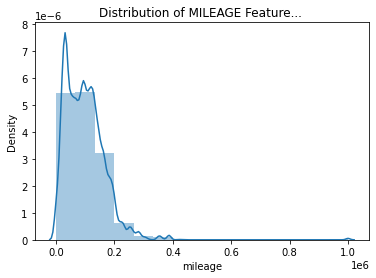

In [214]:
for i, n in enumerate(numerical_features):
    plot_num_hist(df_final, n, i, bins=15)

## **Feature Engineering**

In [232]:
# Remove Unwanted Columns
for c in ['part_code', 'name']:
    ignore_cols.append(c)

selected_cols = [col for col in categorical_features+numerical_features if col not in ignore_cols]
df_final_selected = df_final[selected_cols+[target]]
df_final_selected.sample(frac=1).head()

,damage_code,severity_code,tire_brand_guid,rim_size_guid,lateral_position_type,longitude_position_type,tread_depth_guid,create_userguid,model_year,mileage,num_tires_replaced
78258,14,71,2C24D0F0-858A-C24C-B0CE-8F3C1EFEFC9B,F7AA8E11-3B1E-8542-962E-4480DB4E2BE6,RIGHT,FRONT,CF8810C9-238F-49CE-87C6-33A24CC90179,2CB1E349-7B80-4170-B0B5-3123DA926FF8,2012,165256.0,4
69059,16,71,291CF2A6-57EC-0B48-BE42-6F95113B7C40,DD2960A2-DFEF-B040-BB39-F4D03785BCDE,LEFT,REAR,74231FDE-E1DF-8243-9418-D1756D9BFD4B,3D69E6B3-67EC-40CA-B8DC-1988296043C3,2015,216554.0,0
59458,84,74,EC34273F-2028-AE47-9246-A62A44A9802D,DD2960A2-DFEF-B040-BB39-F4D03785BCDE,LEFT,REAR,8B95CD4A-E78A-7042-875F-103DF2C670BC,EE768823-90DD-4DF2-B4A2-B339DBCFCD0D,2017,20520.0,4
74694,257,55,2017A23F-2347-E241-9350-E8C2A08E6499,DC3A9EA1-6898-9347-91F4-07640CA75574,RIGHT,REAR,4E811E9E-6BE5-9747-8CD7-6A68C179F4FC,29AC4535-11BF-4C5C-9100-548EC3FC067C,2018,32315.0,0
37728,81,9,FDD070AF-647C-944F-83B4-52346E9626B3,DD2960A2-DFEF-B040-BB39-F4D03785BCDE,LEFT,FRONT,A6F6F9ED-943E-9A46-B681-5C32F9D4134D,9834BB8C-CE9E-42BD-80D3-F3562A9272C9,2010,188404.0,2


In [238]:
# Encode Categorical Variables by their index representation

def convert_to_categorical(df, cols):
    for col in cols:
        df[col] = df[col].astype('category', copy=False)
    
    df_encoded = df.copy()
    for col in cols:
        df_encoded[col] = df_encoded[col].cat.codes
    
    return df, df_encoded

_, numerical_features, categorical_features = split_num_cat_features(df_final_selected, defined_numerical_cols=defined_numerical_cols)
processed_df, encoded_df = convert_to_categorical(df_final_selected, categorical_features)
processed_df.head()

,damage_code,severity_code,tire_brand_guid,rim_size_guid,lateral_position_type,longitude_position_type,tread_depth_guid,create_userguid,model_year,mileage,num_tires_replaced
0,17,69,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,REAR,177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2018,1.0,0
1,17,69,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,SECONDAXLE,177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2018,1.0,0
2,17,69,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,RIGHT,REAR,177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2018,1.0,0
3,17,69,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,RIGHT,SECONDAXLE,177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2018,1.0,0
4,89,15,FDD070AF-647C-944F-83B4-52346E9626B3,46D36859-AE06-E54F-8D70-3D4CB2165F9C,LEFT,REAR,177539E2-ACD0-A34F-9131-F430FF9439CC,867B3488-5AAF-4FC4-B85B-19402E3C47EC,2018,1.0,0


In [239]:
encoded_df.head()

,damage_code,severity_code,tire_brand_guid,rim_size_guid,lateral_position_type,longitude_position_type,tread_depth_guid,create_userguid,model_year,mileage,num_tires_replaced
0,11,37,29,3,1,1,0,233,21,1.0,0
1,11,37,29,3,1,2,0,233,21,1.0,0
2,11,37,29,3,2,1,0,233,21,1.0,0
3,11,37,29,3,2,2,0,233,21,1.0,0
4,50,11,29,3,1,1,0,233,21,1.0,0


I like to check for Correlation to see if there are any features I can further remove that is correlated with another.

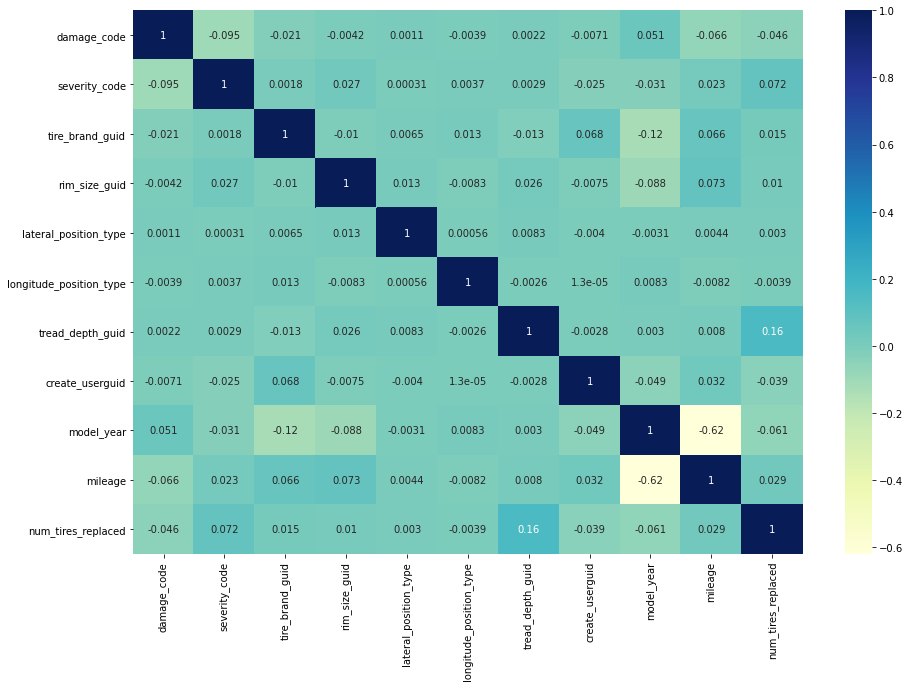

In [237]:
check_correlation(encoded_df)

## Data Splitting: 3-fold

There are many ways to split your data. If I have enough, I like to have a **60/20/20 split** for assurance that my model will generalize.

In [243]:
features = [col for col in encoded_df.columns if col!=target]
train, test = train_test_split(encoded_df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.25, random_state=42)

X_train, y_train = train[features], train[target]
X_valid, y_valid = valid[features], valid[target]
X_test, y_test   = test[features], test[target]

print(len(train), 'train examples')
print(len(valid), 'validation examples')
print(len(test), 'test examples')

56871 train examples
18958 validation examples
18958 test examples


In [244]:
y_train.value_counts()

0    36942
4    15914
2     1760
1     1581
3      674
Name: num_tires_replaced, dtype: int64

In [245]:
y_valid.value_counts()

0    12193
4     5403
2      613
1      527
3      222
Name: num_tires_replaced, dtype: int64

In [246]:
y_test.value_counts()

0    12238
4     5323
2      595
1      558
3      244
Name: num_tires_replaced, dtype: int64

## **Zack's Baseline Modeling** - *Random Forest*

Random Forest has become my baseline and favorite algorithm over the years for a multitude of reasons. One of those reasons is how well it fits any data representation and explains the important features. Here I run some *cross validation and hyperparameter tuning using GridSearch* to ensure I choose a good enough Random Forest config.

*NOTE: I use small parameter values here to preserve compute.*

In [247]:
rf_clf = RandomForestClassifier(class_weight="balanced")

parameters = {"n_estimators": [5, 10, 15], 
              "criterion": ["gini", "entropy"],
              "max_features": ["auto", "sqrt", "log2"], 
              "max_depth": [2, 4, 6], 
              "min_samples_split": [2, 6, 12],
              "min_samples_leaf": [1, 5, 10]
             }

grid_cv = GridSearchCV(rf_clf, parameters, scoring = make_scorer(accuracy_score))
grid_cv = grid_cv.fit(X_train, y_train)

print("Our optimized Random Forest model is:")
grid_cv.best_estimator_

Our optimized Random Forest model is:


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [249]:
rf_clf = grid_cv.best_estimator_
rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)

print(f'Accuracy: {acc_rf}')

Accuracy: 0.562875830783838


I'm quite certain if I had tried a larger number of estimators, along with other hyperparameters, I'd have a strong baseline than **56.3% Accuracy**. But for now, this will suffice.

In [252]:
test_results_rf = pd.DataFrame({'Actual': y_test, 'Predict': pred_rf})
test_results_rf.head(10).transpose()

,94100,19356,90342,15617,44090,52473,46079,9836,21273,27437
Actual,3,0,4,0,0,0,0,0,0,0
Predict,3,3,2,1,0,4,4,0,0,1


In [411]:
def plot_cm(test_results, normalize=None):
    cm = confusion_matrix(test_results['Actual'], test_results['Predict'], normalize=normalize)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4])
    cm_display.plot(values_format='.4g', cmap='GnBu', ax=ax)

# plot_cm(test_results, normalize="true")

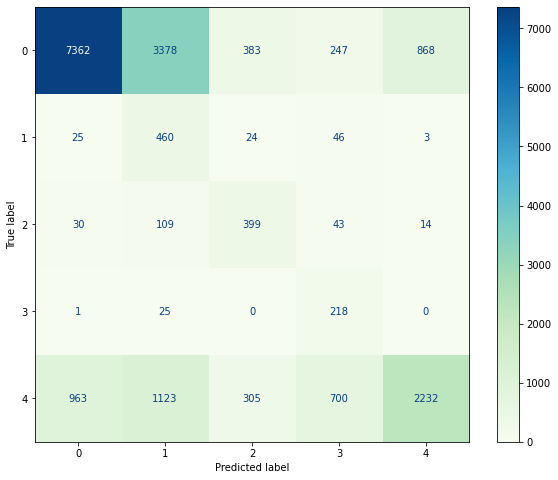

In [275]:
plot_cm(test_results)

The **Confusion Matrix** gives me really good information on how my model is classifying (and misclassfying) the number of replacement tires. Although 0 and 4 has a higher number correctly classified, 1 and 3 both have a higher percentage classified correctly as well. This is surprising considering we have very few examples of those.

### Feature Importance

Although I didn't state it in the beginning, my initial curiousity in `create_userguid` proved to be correct in which I felt it held good information for my model to learn from.

In [328]:
featureImp_list = []
for feat, importance in zip(X_train.columns, rf_clf.feature_importances_):  
    temp = [feat, importance]
    featureImp_list.append(temp)

featureImp_df = pd.DataFrame(featureImp_list, columns = ['Feature', 'Importance'])
featureImp_df.sort_values('Importance', ascending = False)

,Feature,Importance
7,create_userguid,0.294932
6,tread_depth_guid,0.218279
9,mileage,0.189732
8,model_year,0.110524
2,tire_brand_guid,0.085174
3,rim_size_guid,0.071493
0,damage_code,0.013265
1,severity_code,0.010253
5,longitude_position_type,0.003473
4,lateral_position_type,0.002876


## **Model Improvement using TensorFlow & Keras**

I'm always curious to see if I can build a Neural Network to either beat or compete with my baseline model.

The first step I take is converting my data to a **tf.data.Dataset**.

In [337]:
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

train, test = train_test_split(processed_df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.25, random_state=42)

train_ds = df_to_dataset(train, target, batch_size=64)
valid_ds   = df_to_dataset(valid, target, shuffle=False, batch_size=256)
test_ds  = df_to_dataset(test, target, shuffle=False, batch_size=256)

train_ds.element_spec

({'create_userguid': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'damage_code': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'lateral_position_type': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'longitude_position_type': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'mileage': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'model_year': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'rim_size_guid': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'severity_code': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'tire_brand_guid': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'tread_depth_guid': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [342]:
def demo(feature_column, example_batch):
  feature_layer = DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy()[:20])

example_batch = next(iter(train_ds))[0]
demo(tf.feature_column.numeric_column('mileage'), example_batch)

[[ 67344.]
 [177680.]
 [ 91595.]
 [ 69827.]
 [ 32648.]
 [ 15698.]
 [130553.]
 [ 47982.]
 [119963.]
 [ 85333.]
 [ 42239.]
 [ 96812.]
 [254590.]
 [121661.]
 [109858.]
 [ 25460.]
 [ 83824.]
 [ 37287.]
 [ 74163.]
 [ 70958.]]


In [350]:
demo(
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list('longitude_position_type', train.longitude_position_type.unique())), 
    example_batch
)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


### Preprocessing Layers

I've gotten in the habit of including the preprocessing steps as apart of my model. Keras let's me do this by creating them as layers.

In [353]:
def get_normalization_layer(name, dataset):
    normalizer = Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = StringLookup(max_tokens=max_tokens)
    else:
        index = IntegerLookup(max_values=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    feature_ds = feature_ds.map(index)
    
    encoder = CategoryEncoding(max_tokens=index.vocab_size())
    encoder.adapt(feature_ds)

    return lambda feature: encoder(index(feature))

In [376]:
all_inputs   = []
encoded_features = []

_, numerical_features, categorical_features = split_num_cat_features(df_final_selected)

for header in numerical_features:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

for header in categorical_features:
    if df_final[header]
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                                 max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

### Regularized Neural Network

Although only 2 layers, I add L2 weight decay on both of my hidden layers and Dropout to my last hidden layer to help prevent overfitting. Because my classification task is multiclass, I use the **softmax** activation on the output layer.

In [402]:
def build_model(encoded_features):
    Feature_Layer = concatenate(encoded_features)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(Feature_Layer)
    x = Dropout(0.05)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
    output = Dense(5, activation='softmax')(x)
    model = Model(all_inputs, output)

    model.compile(
        optimizer=Adam(lr=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

model = build_model(encoded_features)
model.summary()

def train_model(model, train_ds, valid_ds, epochs=10, batch_size=32, callbacks=None):
    return model.fit(
        train_ds, validation_data=valid_ds,
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks
    )

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tire_brand_guid (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
rim_size_guid (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
lateral_position_type (InputLay [(None, 1)]          0                                            
__________________________________________________________________________________________________
longitude_position_type (InputL [(None, 1)]          0                                            
____________________________________________________________________________________________

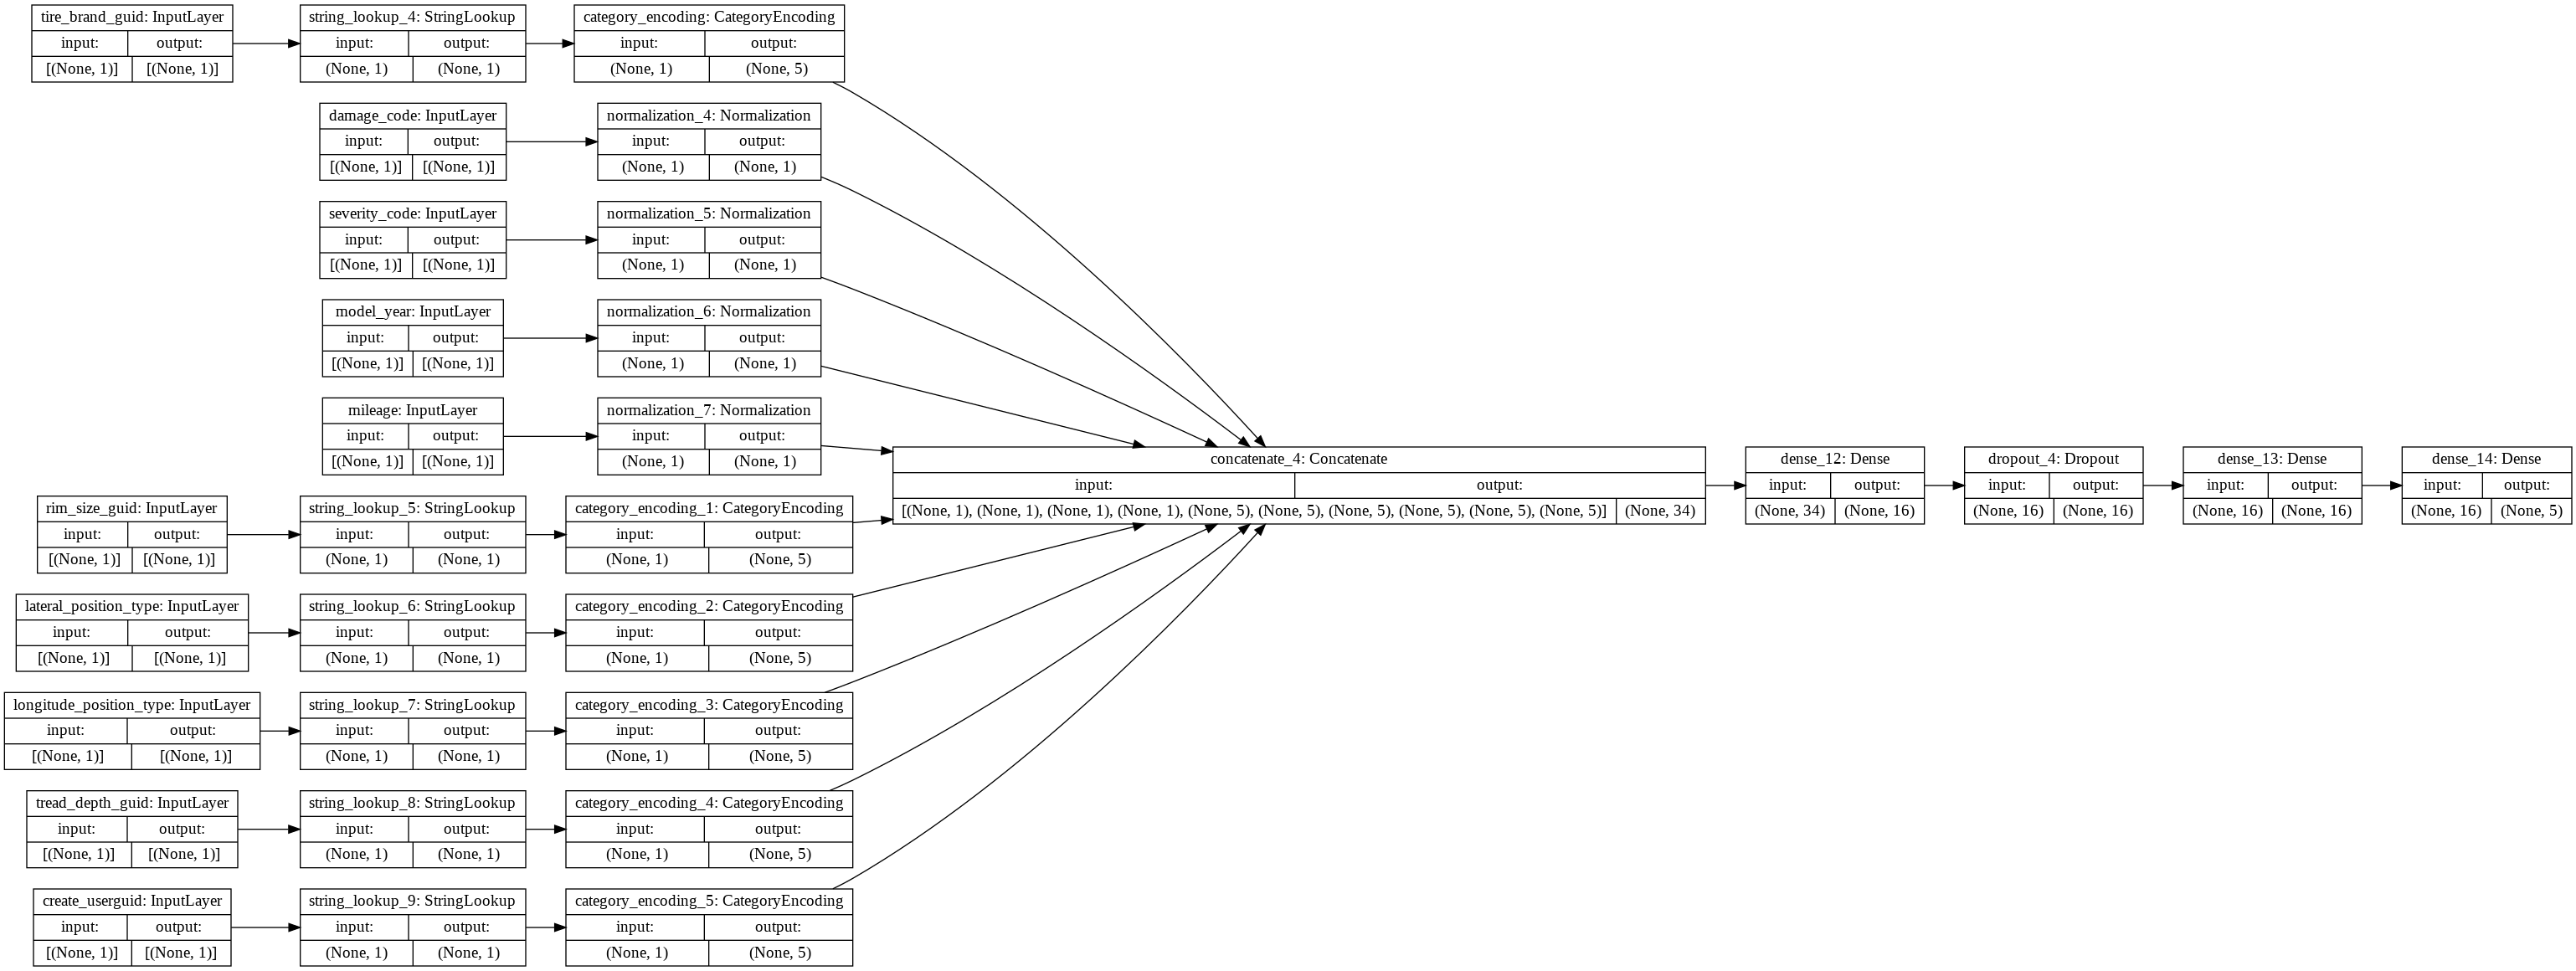

In [403]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

One thing I could've tried differently was sending categorical variables like `model_year`, `severity_code`, etc. through an IntergerLookup instead of normalizing them.

In [404]:
CALLBACKS = [
             ModelCheckpoint(filepath='models/bestModelCheckpoint', # Save and Store best model
                             save_best_only=True, monitor='val_loss', mode='min'),
             EarlyStopping(monitor='val_loss', mode='min', patience=20), # If my model doesn't improve every 20 epochs, stop training
             ReduceLROnPlateau(factor=0.2, patience=10) # Reduce learning rate if model doesn't improve every 10 epochs
]

history = train_model(model, train_ds, valid_ds, callbacks=CALLBACKS, epochs=100)

Epoch 1/100
889/889 [==============================] - 4s 3ms/step - loss: 1.0397 - accuracy: 0.6064 - val_loss: 0.8490 - val_accuracy: 0.6602
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 2/100
889/889 [==============================] - 2s 2ms/step - loss: 0.8360 - accuracy: 0.6719 - val_loss: 0.8278 - val_accuracy: 0.6707
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 3/100
889/889 [==============================] - 2s 2ms/step - loss: 0.8247 - accuracy: 0.6780 - val_loss: 0.8139 - val_accuracy: 0.6837
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 4/100
889/889 [==============================] - 2s 3ms/step - loss: 0.8050 - accuracy: 0.6863 - val_loss: 0.8057 - val_accuracy: 0.6906
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 5/100
889/889 [==============================] - 2s 2ms/step - loss: 0.8025 - accuracy: 0.6910 - val_loss: 0.7977 - val_accuracy: 0.6896
INFO:tens

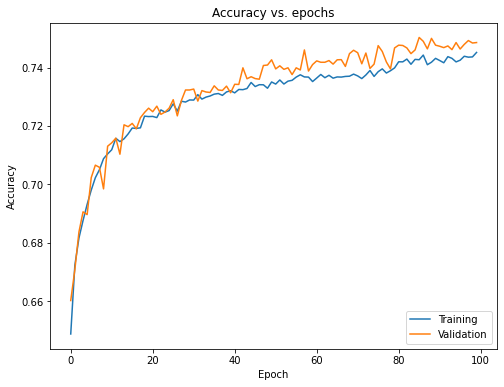

In [405]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

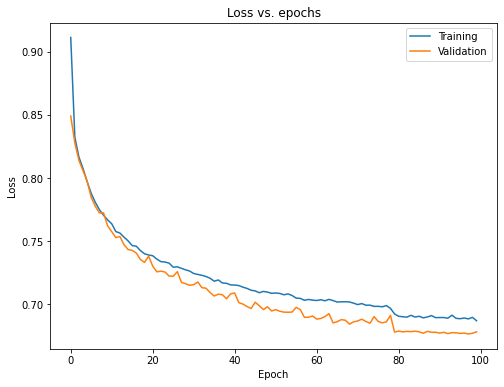

In [406]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [407]:
datasets = {'Training': train_ds,
            'Validation': valid_ds,
            'Testing': test_ds}
for key, ds in datasets.items():
    print(f'{key} Metrics')
    loss, acc  = model.evaluate(ds, verbose=0)
    print(f'Loss    : {round(loss, 3)}')
    print(f'Accuracy: {round(acc, 3)}\n')

Training Metrics
Loss    : 0.669
Accuracy: 0.755

Validation Metrics
Loss    : 0.678
Accuracy: 0.749

Testing Metrics
Loss    : 0.679
Accuracy: 0.746



## **Conclusion**

It seems my neural network performed better than my baseline model. However, I know there are more things I could experiment and evaluate. *Data Science is about experimentation.* Here are a few take aways:

- **Data Schema Validation**. I did verify that the exact same schema and distributions I had in my training set, also existed in my validation and testing set. This also can be a reason my model did better on validation than training. For example, `longitude_position_type` has 4 unique values, but only 3 are present in my training set. However, I think may only 2 to 5 exist in the entire dataset. Therefore I can actually remove the records that contain it since there's not much information there.
- **Dive Deeper into EDA & Feature Engineering**. As stated in the beginning, my EDA and even Feature Engineering was minimal. I could've gotten more detailed information on my missing values, outliers, and improved the imbalance for the classes.
- **Tried more models**. It would've been interesting to try MultiLabel models like OneVsRest that ultimately builds simpler models for each class. This would've allowed me to possibly get the best out of my data representation. I also could've been more creative with my neural network model.
- **Unsupervised Learning**. I could've utilized unsupervised methods to help either help with feature engineering prior to modeling for the classification.

## **Sample Predictions**

In [565]:
import pprint

pp = pprint.PrettyPrinter()

def get_random_sample(data, target):
    idx = np.random.randint(0, data.shape[0])
    sample = dict(data.iloc[idx])
    target_value = sample.pop(target, None)

    print(f'Index {idx}\nTarget Value: {target_value}')
    pp.pprint(sample)
    print('')
    return sample

def predict_single_sample(model, sample):
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
    predictions = model.predict(input_dict)
    prob_precent = round(100 * max(predictions.squeeze()), 2)

    print(f"This vehicle has a(n) {prob_precent}% chance of being a having {predictions.argmax()} tire(s) replaced.")


In [461]:
sample = get_random_sample(test, target)

Index 6655
Target Value: 0


{'create_userguid': '44EB6DDE-3101-4519-AD59-67D3B5CE95E1',
 'damage_code': 64,
 'lateral_position_type': 'RIGHT',
 'longitude_position_type': 'FRONT',
 'mileage': 84989.0,
 'model_year': 2016,
 'rim_size_guid': 'DD2960A2-DFEF-B040-BB39-F4D03785BCDE',
 'severity_code': 74,
 'tire_brand_guid': 'FDD070AF-647C-944F-83B4-52346E9626B3',
 'tread_depth_guid': '8B95CD4A-E78A-7042-875F-103DF2C670BC'}

In [462]:
predict_single_sample(model, sample)

This vehicle has a(n) 80.01% chance of being a having 0 tire(s) replaced.


In [504]:
predict_single_sample(model, get_random_sample(test, target))

Index 1529
Target Value: 3
This vehicle has a(n) 62.09% chance of being a having 0 tire(s) replaced.


In [474]:
predict_single_sample(model, get_random_sample(test, target))

Index 1624
Target Value: 2
This vehicle has a(n) 75.45% chance of being a having 0 tire(s) replaced.


In [475]:
predict_single_sample(model, get_random_sample(test, target))

Index 3295
Target Value: 4
This vehicle has a(n) 99.53% chance of being a having 4 tire(s) replaced.


*Thank you for considering me for this test and position. Hopefully I was able to display and capture my thought process during this challenge.*